In [2]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import scipy
import requests
from imdbpie import Imdb
import nltk
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import nltk
import collections
import re
import csv
import psycopg2
import time
import seaborn as sns

%matplotlib inline

The aim of the project is to collect the data from IMDB API and webscraping results, properly store it for reference, and construct a random forest to understand what factors contribute to ratings in order to provide a report with findings and reccomendations. Fitting a predictive model on features from the descriptions will hopefully shed some light on what features of the movies are most important to viewers as measured by ratings.


In [4]:
imdb = Imdb()
imdb = Imdb(anonymize=True)



Approach plan:

1. Build a scraper to look at top ranked movies by genre sorted by popularity and grab datapoints from the first page of the lists (50 movies) for each genre. 
2. Grab plot summaries using the imdb api
3. Scrape reviews for each unique title in the dataframe resulting from the first two steps and add the text from those as an extra feature for each movie.


In [598]:
#definte a function that will take a beautiful soup object of the page of movie ranks by genre and pull out
#a lot of the data and return a df. In the next step I will iterate through genres to generate urls, read them
#into soup and pass to this function and append results to my big dataframe that will be the corpus for the project
cols = ["id", "title", "genres","stars", 
            "meta", "mins", "rating", "gross", "plot",
           "reviews"]
    
def genre_rank_scrubber(crawler):

    tempdf = pd.DataFrame(columns = cols)
    for movie in crawler:
        
        try:
            
            
            id1 = movie.findChild("div", class_ = "ribbonize")["data-tconst"]
            title = movie.h3.a.text
            genre = str(movie.findChild("span", class_ = "genre").text).strip().replace(",","")
            stars = float(movie.findChild("div", class_ = "inline-block ratings-imdb-rating")["data-value"])
            meta = float(movie.findChild("div", class_ = "inline-block ratings-metascore").span.text)
            mins = int(movie.findChild("span", class_ = "runtime").text.strip("u'min ' '"))
            rating = movie.findChild("span", class_ = "certificate").text
            gross = float(movie.findAll("span", {"name" : "nv"})[1]["data-value"].replace(",",""))

            newrow=pd.Series([id1, title, genre, stars, meta, mins, rating, gross, None, None,], index = cols)
            tempdf = tempdf.append(newrow, ignore_index = 1)
        except: pass
        
    return tempdf

In [599]:
#this is list of genres from imdb site

genres = [ "Action","Adventure", "Animation","Biography","Comedy",
          "Crime", "Drama","Family","Fantasy","Film-Noir","History", 
          "Horror","Music", "Musical", "Mystery", "Romance","Sci-Fi",
          "Sport", "Thriller", "War", "Western"]

base = "http://www.imdb.com/search/title?genres="
tail = "&title_type=feature&num_votes=25000,&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=2406822102&pf_rd_r=0TZ8YKCPETGQ6ZQ0DEBC&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=top&view=advanced&sort=moviemeter,asc&ref_=chttp_gnr_1"

all_movies = pd.DataFrame(columns = cols)

#grab movies sorted by genre by popularity, this way we are not grabbing 
#the highest rated movies but instead movies that 
#are graded as most popular in IMDB, which, judging by the titles 
#looks like it blends recency and number of votes / views received

for genre in genres:
    
    genre_response = requests.get(base+genre+tail)
    genre_soup = BeautifulSoup(genre_response.text)
    crawler = genre_soup.findAll("div", {"class" :"lister-item mode-advanced"})
    all_movies = all_movies.append(genre_rank_scrubber(crawler))
    time.sleep(.1) #bause between requests
    print "Finished with", genre
print "All done"
    

Finished with Action
Finished with Adventure
Finished with Animation
Finished with Biography
Finished with Comedy
Finished with Crime
Finished with Drama
Finished with Family
Finished with Fantasy
Finished with Film-Noir
Finished with History
Finished with Horror
Finished with Music
Finished with Musical
Finished with Mystery
Finished with Romance
Finished with Sci-Fi
Finished with Sport
Finished with Thriller
Finished with War
Finished with Western
All done


In [600]:
all_movies.to_excel("assets/archive1.xls")

In [3]:
movies = pd.read_excel("assets/archive1.xls")

movies.isnull().sum()


id           0
title        0
genres       0
stars        0
meta         0
mins         0
rating       0
gross        0
plot       908
reviews    908
dtype: int64

In [602]:
movies.reset_index(drop = 1, inplace=1)
movies.drop_duplicates(inplace = 1)
len(movies)

499

In [603]:
movies.isnull().sum()

id           0
title        0
genres       0
stars        0
meta         0
mins         0
rating       0
gross        0
plot       499
reviews    499
dtype: int64

In [604]:
movies.index = range(len(movies))

In [605]:
movies.dtypes

id          object
title       object
genres      object
stars      float64
meta         int64
mins         int64
rating      object
gross        int64
plot       float64
reviews    float64
dtype: object

In [606]:
#get plot summaries using the imdb API

for index , value in enumerate(movies["id"]):
    plot = imdb.get_title_plots(value)
    try:
        movies.ix[index,"plot"] = plot[0]
    except:
        movies.ix[index, "plot"] = np.nan

In [607]:
movies["plot"].isnull().sum() #not bad only 8 movies didnt have a plot

8

In [551]:
###getting plot

entry = "tt3850590"
review = imdb.get_title_reviews(entry)


In [554]:
review[0] #well unfortunately the api doesnt work to get reviews so I will do my own scrape here as well

<Review: u'Honestly Universal s'>

In [634]:
movies.head(1)

,id,title,genres,stars,meta,mins,rating,gross,plot,reviews
0,tt1386697,Suicide Squad,Action Adventure Comedy,6.8,40,123,PG-13,238002651,It feels good to be bad...Assemble a team of t...,NaN


In [635]:
#no need to cycle through reviews with a compiling function, i will just add them all to a big string  with a loop
#and put that big string into my frame for each movie with the below

def review_page_grabber(movie): 
    base1 = "http://www.imdb.com/title/"
    tail1 = "/reviews?filter=prolific"
    url = base1+movie+tail1
    review_response = requests.get(url)
    review_soup = BeautifulSoup(review_response.text)
    crawler = review_soup.find("div", {"id" :"tn15content"})
    bigstring = ""
    
    for review in crawler.findAll("p"):\
        
        if len(review.text) > 300:
            
            bigstring += review.text
    time.sleep(.1)
    return bigstring
       

    

In [636]:
#now will run this through and update my frame for each title

for index, value in enumerate(movies["id"]):
    movies.ix[index, "reviews"] = review_page_grabber(value)


In [638]:
movies.isnull().sum()

id         0
title      0
genres     0
stars      0
meta       0
mins       0
rating     0
gross      0
plot       8
reviews    0
dtype: int64

In [639]:
len(movies)

499

In [642]:
movies.dropna(inplace=1)

movies.to_excel("assets/archive2.xlsx")

### START HERE FOR MODEL RESTARTS

In [73]:
####### SCAPING CODE ABOVE TAKES A LONG TIME


movies = pd.read_excel("assets/archive2.xlsx")

print len(movies)
movies.head(1)


491


,id,title,genres,stars,meta,mins,rating,gross,plot,reviews
0,tt1386697,Suicide Squad,Action Adventure Comedy,6.8,40,123,PG-13,238002651,It feels good to be bad...Assemble a team of t...,"\nCall it the Rule of Very Low Expectations, b..."


###  Part 2 Developing Target and Features:

Now that I have the data scraped for about 500 movies I will develop features and start fitting models to predict scores. 

Approach plan:

1. Target will be a 50/50 blend of metacritic score and star score converted to several categorical tiers
2. Initially it might be useful to explore correlations and possibly fit a couple of models just to see the baseline accuracy of preducting using just the minute length, gross revenue, rating and genre to get a baseline accuracy.
3. Use NLKT library and various natural language processing tools to develop features from the reviews and plot summary data to increase accuracy.

In [74]:
print movies.stars.describe()

count    491.000000
mean       7.283299
std        0.854523
min        4.100000
25%        6.750000
50%        7.400000
75%        7.900000
max        9.300000
Name: stars, dtype: float64


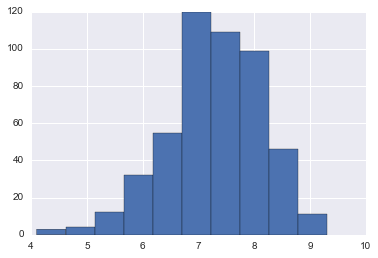

In [75]:
movies.stars.hist(bins = 10)

In [76]:
#looking for good cutoff for categorical value, will aim for top 50% as the high category

movies["target_category"] = ["low" if _<7.4 else "high" for _ in movies.stars]

print pd.Series(movies.target_category).value_counts()
print
print pd.Series(movies.target_category).value_counts() / len(movies)

movies.head(3)

high    246
low     245
Name: target_category, dtype: int64

high    0.501018
low     0.498982
Name: target_category, dtype: float64


,id,title,genres,stars,meta,mins,rating,gross,plot,reviews,target_category
0,tt1386697,Suicide Squad,Action Adventure Comedy,6.8,40,123,PG-13,238002651,It feels good to be bad...Assemble a team of t...,"\nCall it the Rule of Very Low Expectations, b...",low
1,tt4196776,Jason Bourne,Action Thriller,7.0,58,123,PG-13,131687790,Jason Bourne is again being hunted by the CIA....,\nThe first three films in the Bourne franchis...,low
2,tt2660888,Star Trek Beyond,Action Adventure Sci-Fi,7.5,68,122,PG-13,142320158,Day 966 in the USS Enterprise's five year miss...,\nWhether you like the newest Star Trek movie ...,high


#### First lets just see what we can get just basing the rating on gross revenue, minute length and rating, baseline is about 50% since predicting everything as low would get us that accuracy.

In [77]:
#encode y with categories and predict based on mins/gross/rating_dummies

from sklearn.preprocessing import LabelEncoder, RobustScaler

import patsy

le = LabelEncoder()
rs = RobustScaler()

y = le.fit_transform(movies.target_category)
y = y.ravel()

for c in ["gross", "mins"]:
    movies[c] = rs.fit_transform(movies[c].reshape(-1,1))
    
    
X = patsy.dmatrix("~ mins + gross + C(rating)", movies)



In [78]:
#build a multiple function tester

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [79]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in xrange(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [80]:
def evaluate_model(model, labels = None):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = docm(y_test, y_pred, labels = labels)
    cr = classification_report(y_test, y_pred)
    
    print a
    print cm
    print cr
    return a


def cross_val_tester(model):
    
    model.fit(X,y) 
    scores = cross_val_score(model, X, y,
                             cv=StratifiedKFold(y, shuffle=True))
    m = scores.mean()
    s = scores.std()
    
    print model 
    print m 
    print s
    print
    return m




In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 10)

rf = RandomForestClassifier()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
svc = SVC()
lr = LogisticRegression()

models = {}

models["knn"] = {"model":knn}
models["dt"] = {"model": dt}
models["svc"] = {"model": svc}
models["lr"] = {"model": lr}
models["rf"] = {"model" : rf}

In [82]:
names = ["high rating", "low rating"]

for k, v in models.iteritems():
    print k
    v["pred_accuracy"] = evaluate_model(v["model"], labels=names)
    v["mean_cross_val"] = cross_val_tester(v["model"])


knn
0.668918918919
             p_high rating  p_low rating
high rating             51            31
low rating              18            48
             precision    recall  f1-score   support

          0       0.74      0.62      0.68        82
          1       0.61      0.73      0.66        66

avg / total       0.68      0.67      0.67       148

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.670058357025
0.0199373050581

dt
0.581081081081
             p_high rating  p_low rating
high rating             47            35
low rating              27            39
             precision    recall  f1-score   support

          0       0.64      0.57      0.60        82
          1       0.53      0.59      0.56        66

avg / total       0.59      0.58      0.58       148

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max

In [83]:
movies.head(2)

,id,title,genres,stars,meta,mins,rating,gross,plot,reviews,target_category
0,tt1386697,Suicide Squad,Action Adventure Comedy,6.8,40,0.193548,PG-13,1.386237,It feels good to be bad...Assemble a team of t...,"\nCall it the Rule of Very Low Expectations, b...",low
1,tt4196776,Jason Bourne,Action Thriller,7.0,58,0.193548,PG-13,0.500998,Jason Bourne is again being hunted by the CIA....,\nThe first three films in the Bourne franchis...,low


In [84]:
movies["plot"][0]  
#will create a function to tokenize and stem this string so that the countvectorizers work better

u"It feels good to be bad...Assemble a team of the world's most dangerous, incarcerated Super Villains, provide them with the most powerful arsenal at the government's disposal, and send them off on a mission to defeat an enigmatic, insuperable entity. U.S. intelligence officer Amanda Waller has determined only a secretly convened group of disparate, despicable individuals with next to nothing to lose will do. However, once they realize they weren't picked to succeed but chosen for their patent culpability when they inevitably fail, will the Suicide Squad resolve to die trying, or decide it's every man for himself?"

In [85]:

from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def tokenize_stem(string):
    newstring = ""
    for word in word_tokenize(string):
        newstring += stemmer.stem(word) + " "
    return newstring

In [86]:
tokenize_stem(movies["plot"][0])

u"It feel good to be bad ... Assembl a team of the world 's most danger , incarcer Super Villain , provid them with the most power arsen at the govern 's dispos , and send them off on a mission to defeat an enigmat , insuper entiti . U.S. intellig offic Amanda Waller ha determin onli a secretli conven group of dispar , despic individu with next to noth to lose will do . Howev , onc they realiz they were n't pick to succeed but chosen for their patent culpabl when they inevit fail , will the Suicid Squad resolv to die tri , or decid it 's everi man for himself ? "

In [87]:
movies["plot_stem"] = [tokenize_stem(_) for _ in movies["plot"]]
movies.head(2)

,id,title,genres,stars,meta,mins,rating,gross,plot,reviews,target_category,plot_stem
0,tt1386697,Suicide Squad,Action Adventure Comedy,6.8,40,0.193548,PG-13,1.386237,It feels good to be bad...Assemble a team of t...,"\nCall it the Rule of Very Low Expectations, b...",low,It feel good to be bad ... Assembl a team of t...
1,tt4196776,Jason Bourne,Action Thriller,7.0,58,0.193548,PG-13,0.500998,Jason Bourne is again being hunted by the CIA....,\nThe first three films in the Bourne franchis...,low,Jason Bourn is again be hunt by the CIA . It b...


In [88]:
from sklearn.feature_extraction.text import CountVectorizer

In [89]:
cvec = CountVectorizer(stop_words= "english", ngram_range= (1,3))

X = pd.DataFrame(cvec.fit_transform(movies["plot"]).todense(), columns=cvec.get_feature_names())


In [90]:

common_words = []
for i in xrange(2):
    word_count = X[y==i].sum(axis=0)
    print names[i], "most common words"
    cw = word_count.sort_values(ascending = False).head(20)

    print cw
    common_words.extend(cw.index)
    print 

high rating most common words
life      82
world     70
man       64
new       62
love      52
story     49
time      48
young     46
named     40
family    40
old       38
help      36
war       36
years     35
finds     34
year      32
soon      32
father    31
friend    31
team      30
dtype: int64

low rating most common words
life       88
new        74
world      70
love       59
man        48
help       46
family     44
young      43
father     42
school     35
friends    35
team       35
time       34
way        34
city       33
fight      33
finds      33
old        32
years      32
year       30
dtype: int64



In [91]:
#doesnt look to be a lot of discerning features in the plot descriptions. Lets test out the models.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(cvec.fit_transform(movies["plot"]), y, test_size = .3, random_state = 10)

X = cvec.fit_transform(movies.plot_stem)

In [93]:
#test out the same 

rf = RandomForestClassifier()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
svc = SVC()
lr = LogisticRegression()

models = {}

models["knn"] = {"model":knn}
models["dt"] = {"model": dt}
models["svc"] = {"model": svc}
models["lr"] = {"model": lr}
models["rf"] = {"model" : rf}

In [94]:
for k, v in models.iteritems():
    print k
    v["pred_accuracy"] = evaluate_model(v["model"], labels = names)
    v["mean_cross_val"] = cross_val_tester(v["model"])


knn
0.459459459459
             p_high rating  p_low rating
high rating              5            77
low rating               3            63
             precision    recall  f1-score   support

          0       0.62      0.06      0.11        82
          1       0.45      0.95      0.61        66

avg / total       0.55      0.46      0.33       148

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.52134769814
0.0138517123713

dt
0.567567567568
             p_high rating  p_low rating
high rating             46            36
low rating              28            38
             precision    recall  f1-score   support

          0       0.62      0.56      0.59        82
          1       0.51      0.58      0.54        66

avg / total       0.57      0.57      0.57       148

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_

Looks like the plot summaries do not have a great correlation to the star reviews. As a last resort for plot summaries I am going to try and identify the most disciminating words by using the the TfidfVectorizer function and re-test models again.

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words = "english", max_df= .9)


In [96]:
X = tvec.fit_transform(movies.plot_stem)

In [97]:
for k, v in models.iteritems():
    print k
    v["pred_accuracy"] = evaluate_model(v["model"], labels = names)
    v["mean_cross_val"] = cross_val_tester(v["model"])


knn
0.540540540541
             p_high rating  p_low rating
high rating             42            40
low rating              28            38
             precision    recall  f1-score   support

          0       0.60      0.51      0.55        82
          1       0.49      0.58      0.53        66

avg / total       0.55      0.54      0.54       148

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.602848022345
0.0249195645532

dt
0.581081081081
             p_high rating  p_low rating
high rating             49            33
low rating              29            37
             precision    recall  f1-score   support

          0       0.63      0.60      0.61        82
          1       0.53      0.56      0.54        66

avg / total       0.58      0.58      0.58       148

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max

The results still not good so we will move onto the reviews. Although the sample of reviews is not huge at 10 per movie I am hoping that there should be a good correlation here.

The plan of approach will be as follows:

1. stem review words
2. transform reviews using countvectorizer and TfidfVectorizer
3. test all the models first
4. explore word counts and relationships
5. fine tune models


In [98]:
movies["stemmed_reviews"] = [tokenize_stem(_) for _ in movies["reviews"]]

In [99]:

cvec = CountVectorizer(stop_words="english", max_features=10000, ngram_range=(2,3), max_df = .3)
words = pd.DataFrame(cvec.fit_transform(movies["reviews"]).todense(), columns=cvec.get_feature_names())


In [100]:
names = ["high rating", "low rating"]
common_words = []
for i in xrange(2):
    word_count = words[y==i].sum(axis=0)
    print names[i], "most common words"
    cw = word_count.sort_values(ascending = False).head(20)

    print cw
    common_words.extend(cw.index)
    print 

high rating most common words
best film                 164
harry potter              160
best picture              160
nominated best            147
100 greatest              145
best sound                143
true story                136
year old                  125
golden globe nominated    122
globe nominated           122
good film                 115
editing best              111
film really               111
tom hanks                 104
motion picture            103
brad pitt                 103
great film                102
real life                 101
oscar best                100
years ago                 100
dtype: int64

low rating most common words
high school     168
new york        113
adam sandler    104
year old         97
pretty good      97
years ago        92
sci fi           83
looks like       79
johnny depp      79
years later      78
tom cruise       77
good job         76
good movie       74
real life        74
film does        72
feels like       72
snow wh

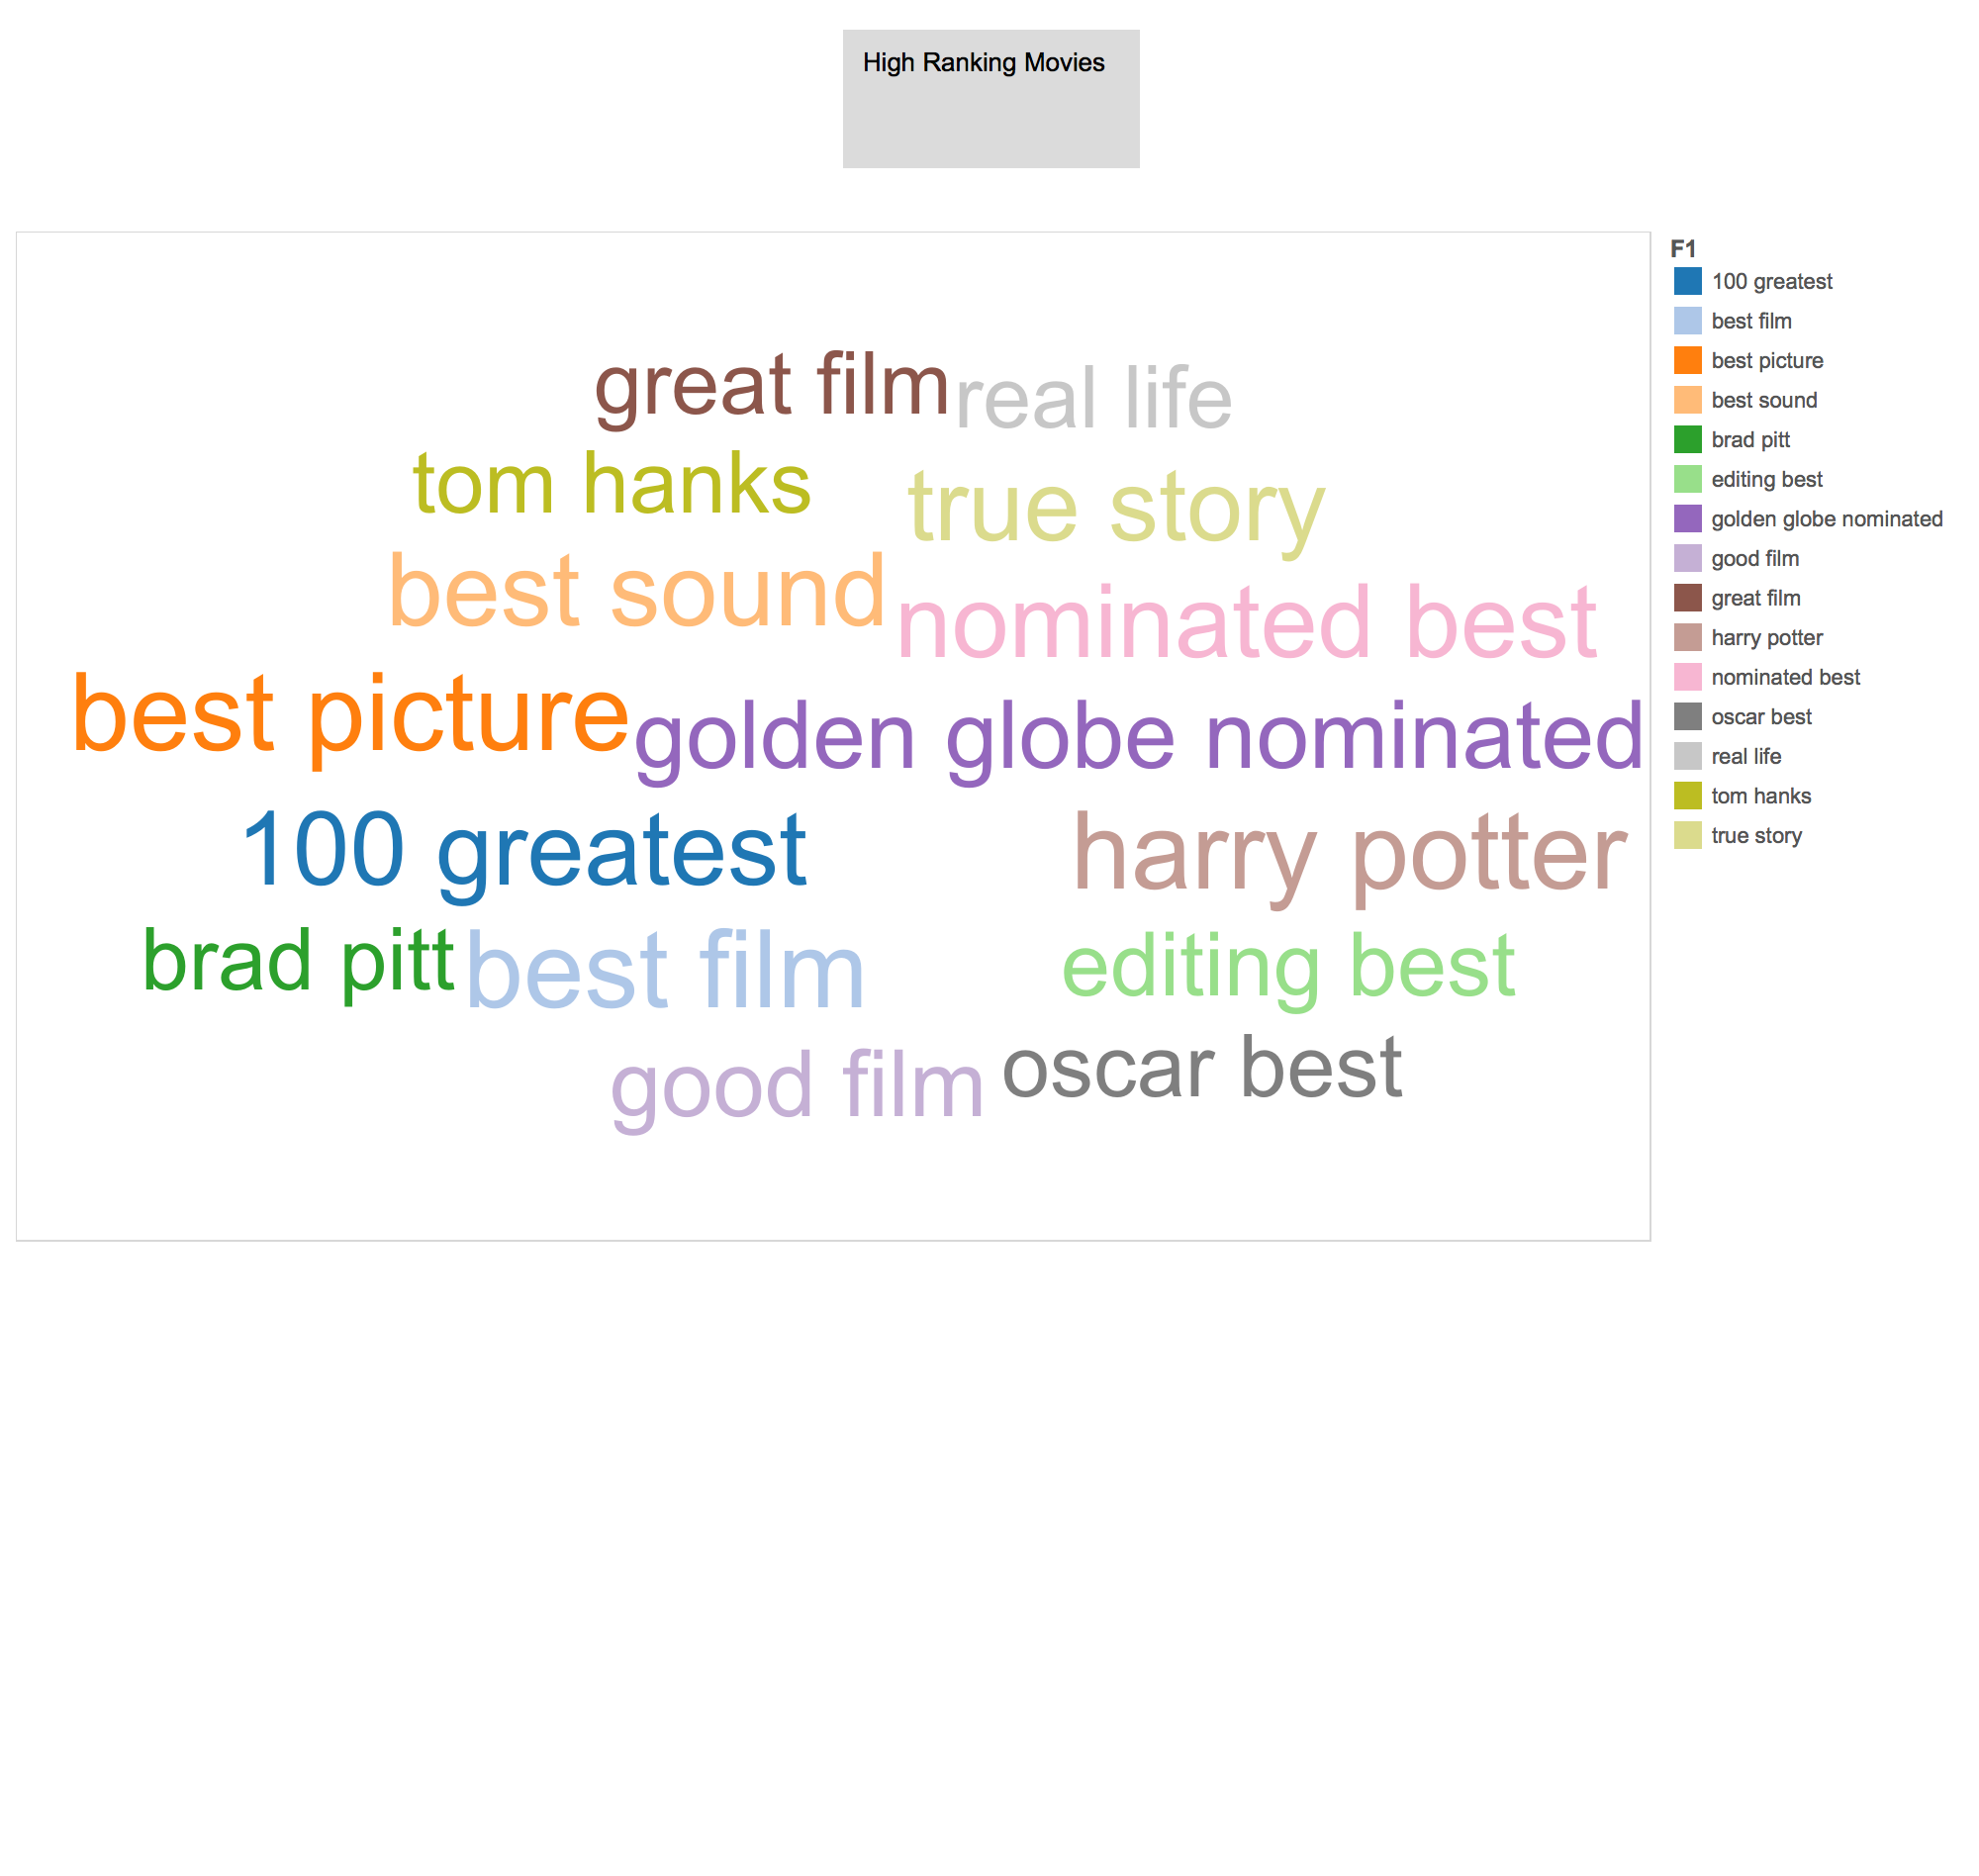

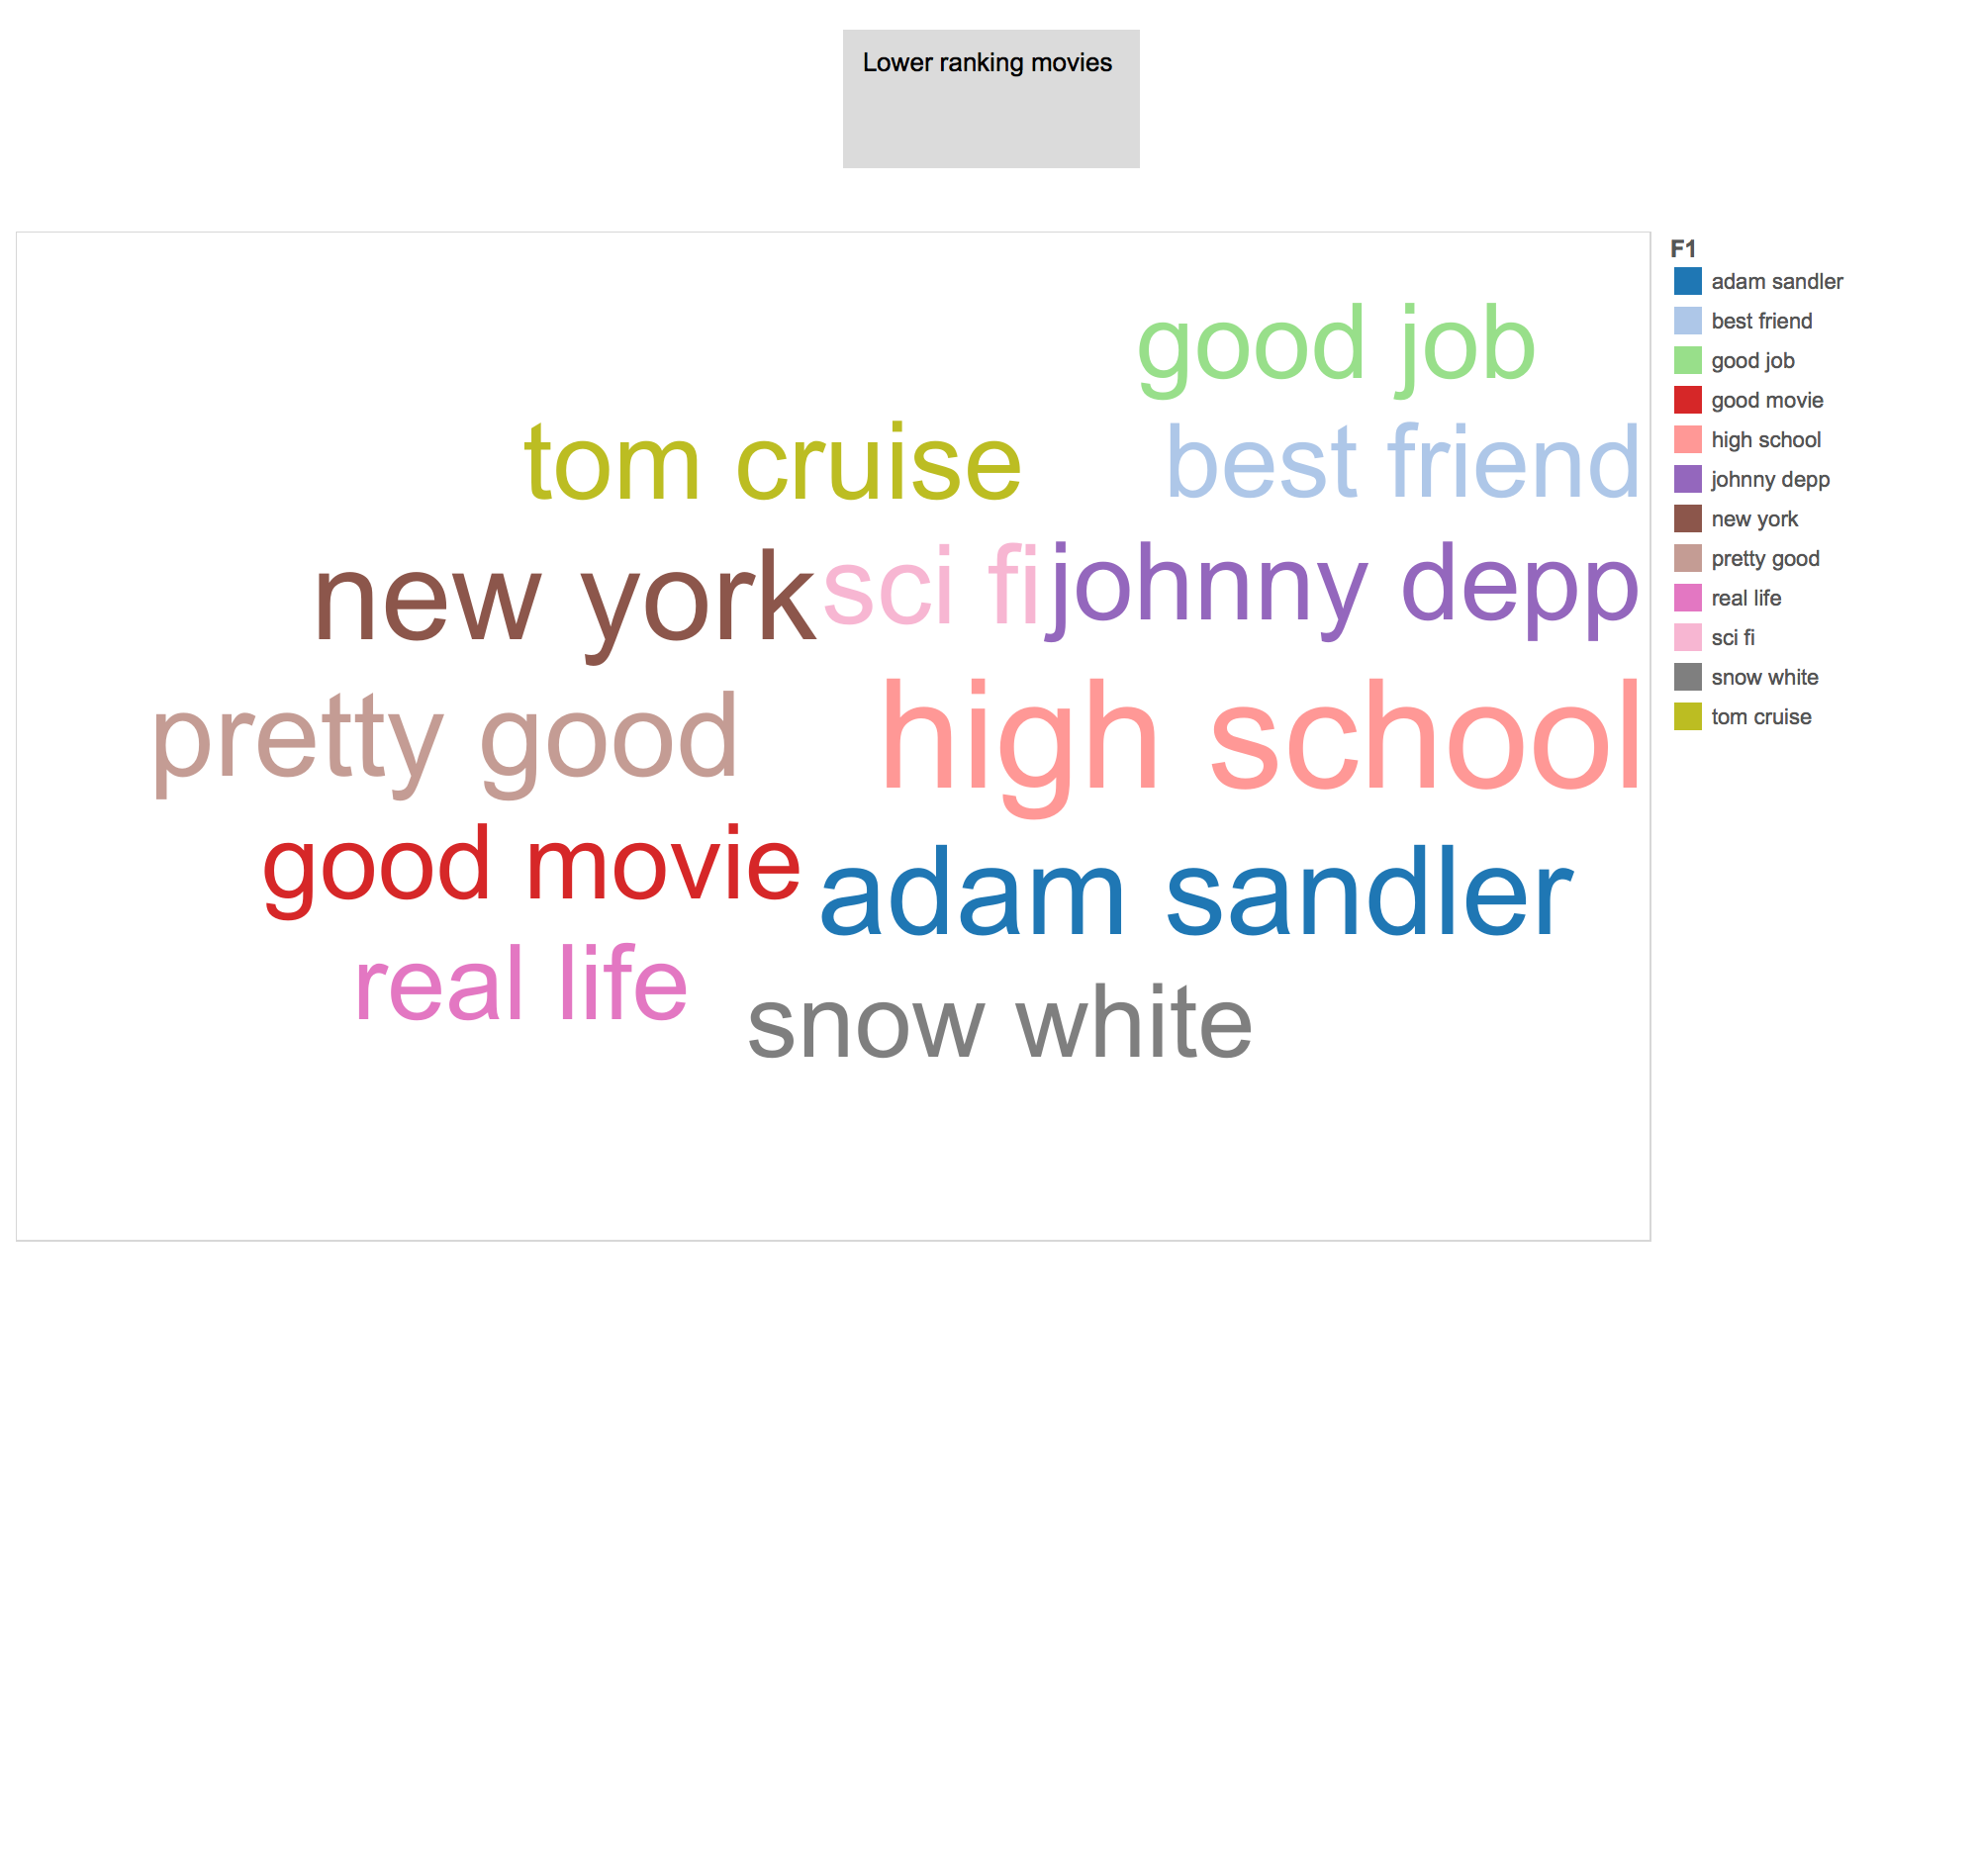

In [4]:
from IPython.display import Image, display 

display(Image(filename='assets/high ranking wordcloud.png'))

display(Image(filename='assets/low ranking wordcloud.png'))

Using count vectorizer seems to be providing some solid differentiating factors here and as an added bonus we have proven the trivial fact that Adam Sandler sucks.

In [101]:
X= cvec.fit_transform(movies["reviews"])

In [102]:
#test out the same 

rf = RandomForestClassifier()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
svc = SVC()
lr = LogisticRegression()

models = {}

models["knn"] = {"model":knn}
models["dt"] = {"model": dt}
models["svc"] = {"model": svc}
models["lr"] = {"model": lr}
models["rf"] = {"model" : rf}

In [103]:
for k, v in models.iteritems():
    print k
    v["pred_accuracy"] = evaluate_model(v["model"], labels = names)
    v["mean_cross_val"] = cross_val_tester(v["model"])


knn
0.47972972973
             p_high rating  p_low rating
high rating              5            77
low rating               0            66
             precision    recall  f1-score   support

          0       1.00      0.06      0.11        82
          1       0.46      1.00      0.63        66

avg / total       0.76      0.48      0.35       148

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.586662676443
0.0576834836144

dt
0.655405405405
             p_high rating  p_low rating
high rating             53            29
low rating              22            44
             precision    recall  f1-score   support

          0       0.71      0.65      0.68        82
          1       0.60      0.67      0.63        66

avg / total       0.66      0.66      0.66       148

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_

Still not great results here although random forest looks promising in the cross validation. Going to see if I get a better result using 1 word ngrams, after that we can fine tune the model with bagging and gridsearch tools and then eventually using random forests.

In [104]:
cvec = CountVectorizer(stop_words= "english", ngram_range=(1,1))

In [105]:
X = cvec.fit_transform(movies["stemmed_reviews"])

for k, v in models.iteritems():
    print k
    v["pred_accuracy"] = evaluate_model(v["model"], labels = names)
    v["mean_cross_val"] = cross_val_tester(v["model"])




knn
0.72972972973
             p_high rating  p_low rating
high rating             64            18
low rating              22            44
             precision    recall  f1-score   support

          0       0.74      0.78      0.76        82
          1       0.71      0.67      0.69        66

avg / total       0.73      0.73      0.73       148

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.73521123248
0.0109290584396

dt
0.716216216216
             p_high rating  p_low rating
high rating             57            25
low rating              17            49
             precision    recall  f1-score   support

          0       0.77      0.70      0.73        82
          1       0.66      0.74      0.70        66

avg / total       0.72      0.72      0.72       148

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_f

Lets try adding bagging to decision trees to really fine tune the model.

In [106]:
cvec = CountVectorizer(stop_words="english", max_features=10000, ngram_range=(2,3))

X= pd.DataFrame(cvec.fit_transform(movies["reviews"]).todense(), columns = cvec.get_feature_names())



In [107]:
X.join(movies[["gross", "mins"]] ) #add in the columns for gross revenue and minute length
len(X)

491

In [108]:
X.index

RangeIndex(start=0, stop=491, step=1)

In [109]:
ratings = patsy.dmatrix("C(rating)", movies)
ratings = pd.DataFrame(ratings)


X.join(ratings)
len(X)

491

In [110]:



from sklearn.grid_search import GridSearchCV


params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gsdt = GridSearchCV(dt,
                    params,
                    cv=KFold(len(y), n_folds=3, shuffle=True))

gsdt.fit(X, y)
print gsdt.best_params_
print gsdt.best_score_



{'min_samples_split': 2, 'splitter': 'random', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3}
0.682281059063


In [111]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')


bagging_params = {'n_estimators': [10, 20, 50, 100],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.7, 1.0],
                  'bootstrap_features': [True, False]}


gsbaggingdt = GridSearchCV(BaggingClassifier(gsdt.best_estimator_),
                           bagging_params, n_jobs=4,
                           cv=KFold(len(y), n_folds=3, shuffle=True))

gsbaggingdt.fit(X, y)

print gsbaggingdt.best_params_
print gsbaggingdt.best_score_

{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'bootstrap_features': True}
0.761710794297


In [112]:
evaluate_model(gsbaggingdt.best_estimator_, labels = names)

0.756756756757
             p_high rating  p_low rating
high rating             53            29
low rating               7            59
             precision    recall  f1-score   support

          0       0.88      0.65      0.75        82
          1       0.67      0.89      0.77        66

avg / total       0.79      0.76      0.76       148



0.7567567567567568

In [113]:
gsbaggingdt.best_estimator_.fit(X,y)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random'),
         bootstrap=True, bootstrap_features=True, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [114]:
feature_importance = pd.DataFrame(gsdt.best_estimator_.feature_importances_, 
                                  index = X.columns, columns = ["importance"]).sort_values("importance",
                                                                                          ascending = False)
feature_importance.head(20)

,importance
best sound,0.130778
10 10 bethany,0.057239
best writing,0.041944
nominated oscar best,0.030192
best film,0.026773
doesn disappoint,0.024998
right end,0.024489
bit problem,0.023998
know story,0.023063
giving great,0.023049


In [115]:
cross_val_tester(gsbaggingdt.best_estimator_)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random'),
         bootstrap=True, bootstrap_features=True, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
0.737293630605
0.0308988639627



0.73729363060501774

In [116]:
evaluate_model(gsbaggingdt.best_estimator_, labels = names)

0.709459459459
             p_high rating  p_low rating
high rating             46            36
low rating               7            59
             precision    recall  f1-score   support

          0       0.87      0.56      0.68        82
          1       0.62      0.89      0.73        66

avg / total       0.76      0.71      0.70       148



0.70945945945945943

In [117]:


params = {'n_estimators':[3, 5, 10, 50, 100],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(len(y), n_folds=3, shuffle=True))

gsrf.fit(X, y)
print gsrf.best_params_
print gsrf.best_score_

{'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'gini', 'max_depth': None, 'class_weight': 'balanced'}
0.775967413442


In [118]:
cross_val_tester(gsrf.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.775923986234
0.0180686846156



0.77592398623372738

In [119]:
evaluate_model(gsrf.best_estimator_, labels = names)

0.763513513514
             p_high rating  p_low rating
high rating             59            23
low rating              12            54
             precision    recall  f1-score   support

          0       0.83      0.72      0.77        82
          1       0.70      0.82      0.76        66

avg / total       0.77      0.76      0.76       148



0.76351351351351349

In [120]:
### now onto extra trees

params = {'n_estimators':[3, 5, 10, 50, 100],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


gset = GridSearchCV(ExtraTreesClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(len(y), n_folds=3, shuffle=True))

gset.fit(X, y)
print gset.best_params_
print gset.best_score_

{'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'gini', 'max_depth': None, 'class_weight': None}
0.786150712831


In [121]:
cross_val_tester(gset.best_estimator_)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.778106139957
0.0419246454981



0.77810613995710509

In [122]:
evaluate_model(gset.best_estimator_, labels = names)

0.77027027027
             p_high rating  p_low rating
high rating             59            23
low rating              11            55
             precision    recall  f1-score   support

          0       0.84      0.72      0.78        82
          1       0.71      0.83      0.76        66

avg / total       0.78      0.77      0.77       148



0.77027027027027029

In [123]:
#ok, looks like using extra random trees doesnt actually increase accuracy over the regular random forest model

In [124]:
feature_importance = pd.DataFrame(gset.best_estimator_.feature_importances_, 
                                  index = X.columns, columns = ["importance"]).sort_values("importance",
                                                                                          ascending = False)
feature_importance.head(20)

,importance
best film,0.007580
film felt,0.006657
nominated best,0.006247
baftas best,0.005997
editing best,0.005876
special visual effects,0.005814
imdb 250,0.005303
won oscars,0.004891
best editing,0.004657
special visual,0.004335


Looks like decent performance here both on the cross validation and the train test split tests. Also the feature importance is consistent with what was yielded by earlier word vectorization exercises. The determining factors seem to point to award nominations and praise of cinematography as those correlating highly with high ratings in reviews. 

The recommendation to netflix therefore would be to target award nominated movies with super sweet special effects in their suggestings and visible queue positions. 




Lastly lets try some boosted methods:


In [125]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()

In [126]:
cross_val_tester(gbc)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
0.704661080353
0.0285462884149



0.70466108035313491

In [127]:
evaluate_model(gbc, labels = names)

0.75
             p_high rating  p_low rating
high rating             56            26
low rating              11            55
             precision    recall  f1-score   support

          0       0.84      0.68      0.75        82
          1       0.68      0.83      0.75        66

avg / total       0.77      0.75      0.75       148



0.75

In [128]:
cross_val_tester(abc)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
0.692478427852
0.0253679242834



0.69247842785176317

In [129]:
evaluate_model(abc, labels = names)

0.689189189189
             p_high rating  p_low rating
high rating             53            29
low rating              17            49
             precision    recall  f1-score   support

          0       0.76      0.65      0.70        82
          1       0.63      0.74      0.68        66

avg / total       0.70      0.69      0.69       148



0.68918918918918914

Looks like the Gradient Booster is giving better performance. As a next step I will try to tune the parameters using grid search.


In [130]:
params = {
          'loss': ['deviance', 'exponential'],
          'max_depth' : [3,5,7]
          }


gsgb = GridSearchCV(GradientBoostingClassifier(),
                    params, n_jobs=-1,
                    cv=KFold(len(y), n_folds=3, shuffle=True))

gsgb.fit(X, y)
print gset.best_params_
print gset.best_score_

{'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'gini', 'max_depth': None, 'class_weight': None}
0.786150712831


In [131]:
cross_val_tester(gsgb.best_estimator_)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
0.749451344207
0.0262663152461



0.74945134420669357

In [132]:
evaluate_model(gsgb.best_estimator_, labels = names)

0.756756756757
             p_high rating  p_low rating
high rating             57            25
low rating              11            55
             precision    recall  f1-score   support

          0       0.84      0.70      0.76        82
          1       0.69      0.83      0.75        66

avg / total       0.77      0.76      0.76       148



0.7567567567567568

So in this case boosting did not seem to increase the performance.